## import

In [1]:
import time
import pandas as pd
import numpy as np
import healpy as hp
from astropy.io import fits
import matplotlib.pyplot as plt
from jupyterthemes import jtplot

%config InlineBackend.figure_format = 'retina'                                    # so you can see plots in HD :) 
#colors = sns.color_palette("colorblind").as_hex()
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)
NSIDE = 2048                                                                      # given in the name of the maps

## extract CMB maps and masks

In [2]:
def extract_data(filepath, hdu=1):
    '''
    Extracts input HDU from map Planck FITS file (we only need the first one)
    Document function once fully tested
    '''
    
    hdul = fits.open(filepath)
    data = hdul[hdu].data                    # hdul is a list of HDU objects

    hdul.info()                              # prints metadata about FITS file (HDUs)
    print('='*90)
    hdul.close()                    
    
    return data

# Define each filepath
filenames = ['HFI_SkyMap_143_2048_R3.01_halfmission-1.fits',        # map for half mission 1 143 GHZ
             'HFI_SkyMap_143_2048_R3.01_halfmission-2.fits',        # map for half mission 2 143 GHZ
             'HFI_Mask_GalPlane-apo0_2048_R2.00.fits',              # galactic plane mask for APO..
             'HFI_Mask_PointSrc_2048_R2.00.fits',                   # mask point source
             'Bl_T_R3.01_fullsky_143hm1x143hm1.fits',               # beam transfer function for hm1
             'Bl_T_R3.01_fullsky_143hm1x143hm2.fits',               # beam transfer function for hm2
            ]

start1 = time.time()
# extract data
datalist = []
for filename in filenames:
    data_i = extract_data('data/'+filename)
    datalist.append(data_i)
end1 = time.time()
print(f'It took {end1-start1:.2f}s. to extract the Planck data files.')

sky_hm1, sky_hm2, mask_gp, mask_ps = datalist[:4]
beamf_hm1, beamf_hm2 = datalist[4:]

Filename: data/HFI_SkyMap_143_2048_R3.01_halfmission-1.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  FREQ-MAP      1 BinTableHDU     75   50331648R x 10C   ['E', 'E', 'E', 'J', 'E', 'E', 'E', 'E', 'E', 'E']   
Filename: data/HFI_SkyMap_143_2048_R3.01_halfmission-2.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  FREQ-MAP      1 BinTableHDU     75   50331648R x 10C   ['E', 'E', 'E', 'J', 'E', 'E', 'E', 'E', 'E', 'E']   
Filename: data/HFI_Mask_GalPlane-apo0_2048_R2.00.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  GAL-MASK      1 BinTableHDU     54   50331648R x 8C   ['B', 'B', 'B', 'B', 'B', 'B', 'B', 'B']   
Filename: data/HFI_Mask_PointSrc_2048_R2.00.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   () 

## compute spherical harmoncis

In [3]:
def find_spherical_harmonics(map_table, gp_table, ps_table, apply_mask=True,
                             stoke_param ='I_STOKES', galactic_plane='GAL060', 
                             frequency=143, NSIDE=2048):
    '''
    Computes the spherical harmonics from a map,
    masking the stokes parameters from the raw CMB data
    Fully document function once fully tested
    '''
    
    start = time.time()
    
    # extract stoke parameter (T or I by default) and mask based on galactic plane and point source
    x = map_table[stoke_param]
    
    if apply_mask:
        gp_mask = gp_table[galactic_plane]
        ps_mask = ps_table[f'F{frequency}']
        x_masked = x*gp_mask*ps_mask
    else:
        x_masked = x
    
    # compute spherical harmonics
    a_lm =  hp.sphtfunc.map2alm(x_masked, pol=False, lmax=4000)               # lmax=4000 is a good estimate, default is #*NSIDE-1
    
    end = time.time()
    print(f'It took {end-start:.2f} s. to compute a_lm')
    
    return a_lm

# Call function
a_lm_1 = find_spherical_harmonics(sky_hm1, mask_gp, mask_ps)
a_lm_2 = find_spherical_harmonics(sky_hm2, mask_gp, mask_ps)

It took 252.09 s. to compute a_lm
It took 307.04 s. to compute a_lm


## double check that there are no undefined pixels in the masked map

In [4]:
# check whether the map has any undefined pixels
hm1_masked = sky_hm1['I_STOKES']*mask_gp['GAL040']*mask_ps[f'F143']
hm2_masked = sky_hm2['I_STOKES']*mask_gp['GAL040']*mask_ps[f'F143']
undef_hm1, undef_hm2 = np.where(~np.isfinite(hm1_masked)), np.where(~np.isfinite(hm2_masked)) 

print(undef_hm1)
print(undef_hm2)

(array([], dtype=int64),)
(array([], dtype=int64),)


## compute actual cross power spectrum

In [5]:
def find_power_spectrum(alm_1, alm_2, bl_1, bl_2,
                        M_ll=1, f_l=1, n_l=0, NSIDE=2048):
    '''
    Finds the cross-power spectrum (via pseudo cross power spectrum) given the 
    coefficients of the spherical harmonics
    Document function once fully tested
    '''
    
    start = time.time()
    # compute pseudo power spectrum
    D_l = hp.sphtfunc.alm2cl(alm_1, alm_2)
        
    # now define all the instrument related biases
    bl_1, bl_2 = bl_1.astype(np.float), bl_2.astype(np.float)
    p_l = hp.sphtfunc.pixwin(NSIDE, lmax=len(bl_1)-1)
    
    # calculate the unbinned cross power spectrum
    C_l = D_l/(p_l**2 * bl_1*bl_2)
    
    # binning C_l
    
    end = time.time()
    print(f'It took {end-start:.2f} s. to compute C_l')
    
    return C_l

C_l = find_power_spectrum(a_lm_1, a_lm_2, beamf_hm1, beamf_hm2)

It took 2.51 s. to compute C_l


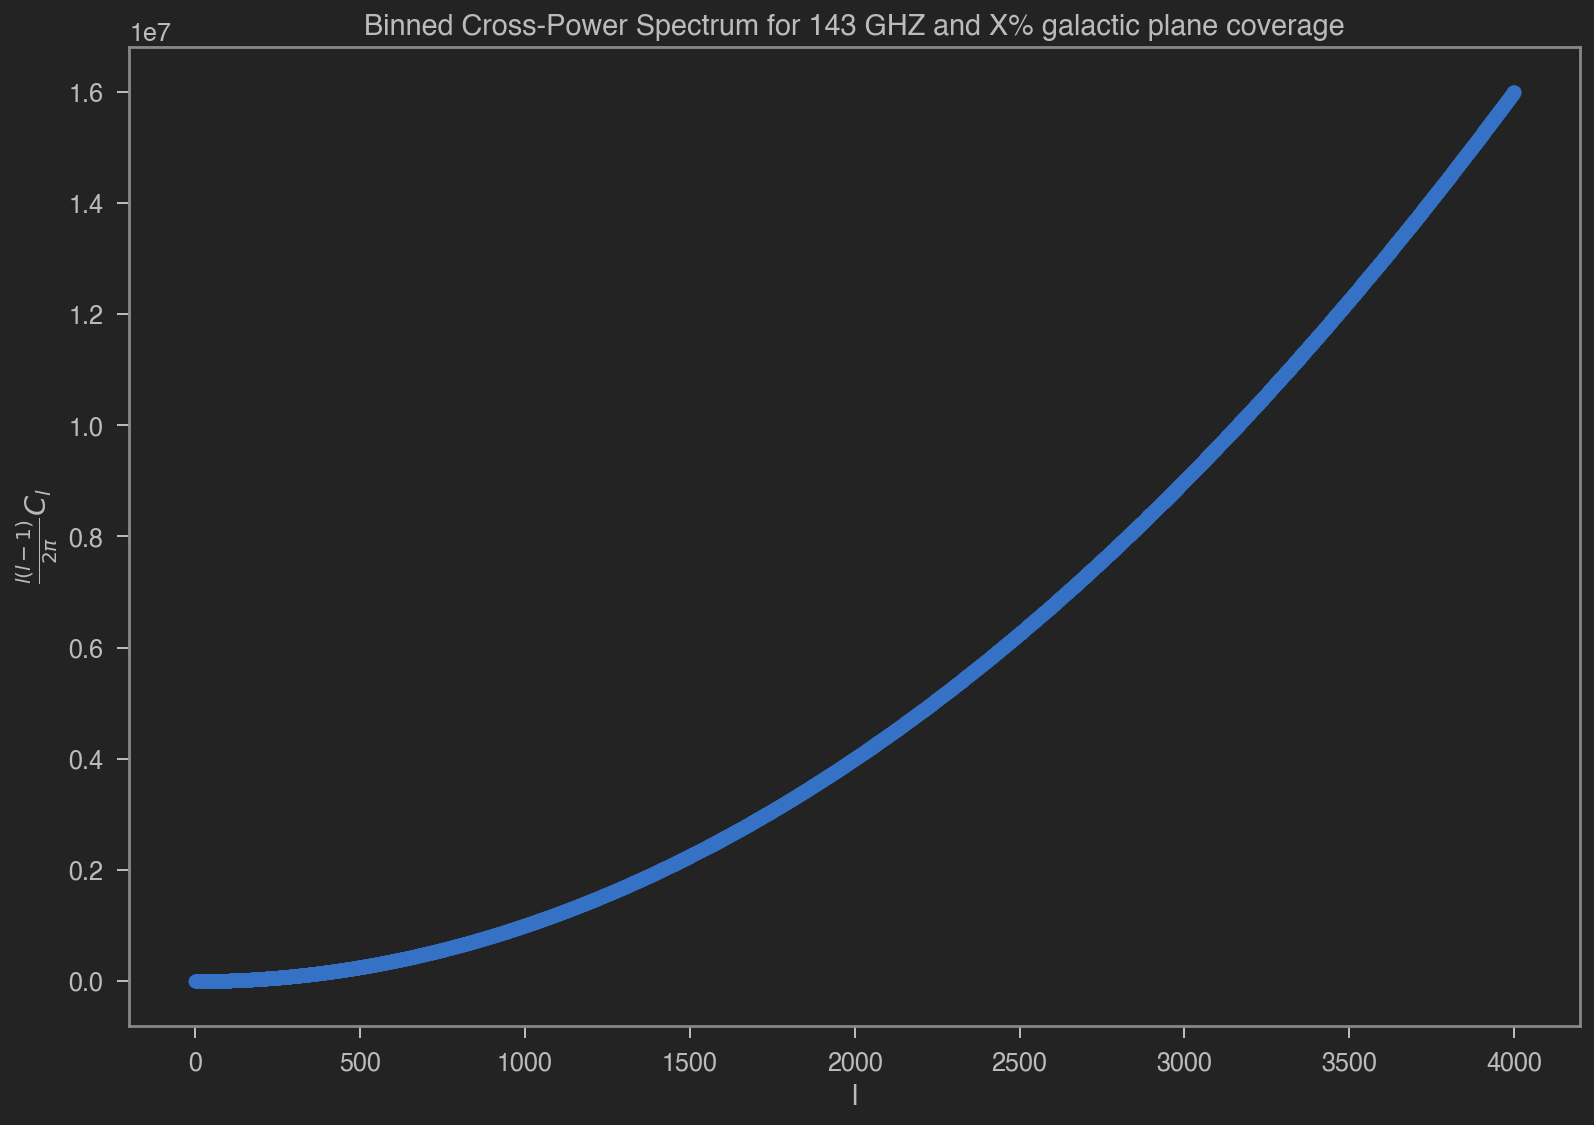

In [6]:
l = np.arange(len(C_l))
C_l_binned = l*(l+1)+C_l/(2*np.pi)
galperc = 'X'

fig, ax = plt.subplots(figsize=(13,9))

ax.plot(l, C_l_binned, 'o')
#ax.set_xlim([3500,4000])

ax.set_xlabel('l')
ax.set_ylabel(r'$\frac{l(l-1)}{2\pi} C_l$')
ax.set_title(f'Binned Cross-Power Spectrum for 143 GHZ and {galperc}% galactic plane coverage')

plt.show()

In [7]:
hdul = fits.open('data/HFI_Mask_GalPlane-apo5_2048_R2.00.fits')
print(hdul[1].header)
hdul.close()

print(mask_gp['GAL099'])

XTENSION= 'BINTABLE'           /Written by IDL:  Tue Dec  9 17:16:06 2014       BITPIX  =                    8 /                                                NAXIS   =                    2 /Binary table                                    NAXIS1  =                   32 /Number of bytes per row                         NAXIS2  =             50331648 /Number of rows                                  PCOUNT  =                    0 /Random parameter count                          GCOUNT  =                    1 /Group count                                     TFIELDS =                    8 /Number of columns                               COMMENT                                                                         COMMENT  *** End of mandatory fields ***                                        COMMENT                                                                         EXTVER  =                    1 /Extension version                               DATE    = '2014-12-09'         /Creation